### Natural Language Processing Assignment

#### Course: TIPP Intake 1

#### Student Name: Koay Seng Tian (sengtian@yahoo.com)

Note: by typing your full name, it is taken that you have read and understood the declaration below.

#### Declaration:

- I declare that this report is my original work. I understand that if I am suspected of plagiarism, my enrolment in the programme may be terminated.

- I declare that I have a back-up electronic copy of this report for immediate submission.


In [16]:
from datetime import datetime 
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF
from wordcloud import WordCloud

import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pyLDAvis
import pyLDAvis.sklearn
import re
import string

In [2]:
num_topics = 20
num_top_words = 20

# for reproducibility, 1337 is arbitrarily set
np.random.seed(1337)

# Load Dataset

In [3]:
# dataset file name and its full pathname
dataset_filename = 'News Set A.csv'
dataset_dir = 'datasets'
dataset_fullpathname = os.path.join(os.getcwd(), dataset_dir)
dataset_fullpathname = os.path.join(dataset_fullpathname, dataset_filename)

# load the "News Set A.csv" as a dataframe
# and drop the first unnamed index column
df = pd.read_csv(dataset_fullpathname, encoding='utf-8', error_bad_lines=False)
df.drop(df.columns[0], axis=1)

,id,title,publication,author,date,year,month,url,content
0,17283,House Republicans Fret About Winning Their Hea...,New York Times,Carl Hulse,2016-12-31,2016.0,12.0,NaN,WASHINGTON — Congressional Republicans have...
1,17284,Rift Between Officers and Residents as Killing...,New York Times,Benjamin Mueller and Al Baker,2017-06-19,2017.0,6.0,NaN,"After the bullet shells get counted, the blood..."
2,17285,"Tyrus Wong, ‘Bambi’ Artist Thwarted by Racial ...",New York Times,Margalit Fox,2017-01-06,2017.0,1.0,NaN,"When Walt Disney’s “Bambi” opened in 1942, cri..."
3,17286,"Among Deaths in 2016, a Heavy Toll in Pop Musi...",New York Times,William McDonald,2017-04-10,2017.0,4.0,NaN,"Death may be the great equalizer, but it isn’t..."
4,17287,Kim Jong-un Says North Korea Is Preparing to T...,New York Times,Choe Sang-Hun,2017-01-02,2017.0,1.0,NaN,"SEOUL, South Korea — North Korea’s leader, ..."
...,...,...,...,...,...,...,...,...,...
49995,73465,"Rex Tillerson Says Climate Change Is Real, but …",Atlantic,Robinson Meyer,2017-01-11,2017.0,1.0,NaN,"As chairman and CEO of ExxonMobil, Rex Tillers..."
49996,73466,The Biggest Intelligence Questions Raised by t...,Atlantic,Amy Zegart,2017-01-11,2017.0,1.0,NaN,I’ve spent nearly 20 years looking at intellig...
49997,73467,Trump Announces Plan That Does Little to Resol...,Atlantic,Jeremy Venook,2017-01-11,2017.0,1.0,NaN,Donald Trump will not be taking necessary st...
49998,73468,Dozens of For-Profit Colleges Could Soon Close,Atlantic,Emily DeRuy,2017-01-11,2017.0,1.0,NaN,Dozens of colleges could be forced to close ...


# Clean the Data

In [4]:
def clean_text(text):
    # change to lower case
    text = text.lower()

    # remove words containing numbers
    text = re.sub(r'\w*\d\w*', '', text)
    
    # remove punctuations\n",
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)
    # remove punctuation marks specifics to this dataset
    text = re.sub(r'[—’“”]', ' ', text)
    
    # remove words less than 3 characters
    text = re.sub(r'\b\w{1,3}\b', ' ', text)
    
    # remove extra spaces
    text = re.sub(r'\s+', ' ', text)
    
    return text

In [5]:
docs = pd.DataFrame(df.content.apply(lambda x: clean_text(x)))

In [6]:
docs = docs.content.values

In [7]:
type(docs)
docs.shape

numpy.ndarray

(50000,)

In [8]:
docs[4]

'seoul south korea north korea leader said sunday that country making final preparations conduct first test intercontinental ballistic missile bold statement less than month before inauguration donald trump although north korea conducted five nuclear tests last decade more than ballistic missile tests alone although habitually threatens attack united states with nuclear weapons country never intercontinental ballistic missile icbm annual year speech which broadcast north kctv sunday spoke proudly strides said country made nuclear weapons ballistic missile programs said north korea would continue bolster weapons programs long united states remained hostile continued joint military exercises with south korea have reached final stage preparations intercontinental ballistic rocket said analysts region have said might conduct another weapons test coming months taking advantage leadership changes united states south korea trump will sworn south korea president park whose powers were suspende

# Exploratory Data Analysis

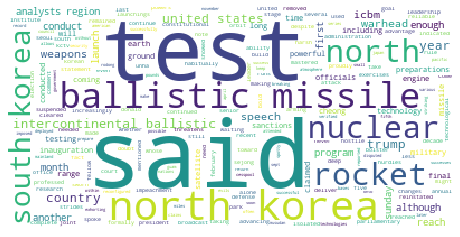

In [9]:
# generate word cloud
def showWordCloud(texts):
    words = ','.join(list(texts))
 
    # show it as wordCloud
    wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
    wordcloud.generate(words)
    
    plt.figure(figsize=(8, 8))
    plt.axis('off')
    plt.imshow(wordcloud.to_image())
    
# show a word cloud for news ID #17287
showWordCloud(docs[4].split())

In [10]:
# extracted from NLP lab exercise
# also same function can be found in scikit-learn website
def display_top_words(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))
        print()


# Latent Dirichlet Allocation Analysis

In [11]:
# LDA

# create Document-Word matrix
vectorizer = CountVectorizer(analyzer='word',
                             max_df=0.9,
                             min_df=5, 
                             stop_words='english',
                             lowercase=True)
data_vectorized = vectorizer.fit_transform(docs)


In [12]:
# build a LDA model

lda_model = LatentDirichletAllocation(
    n_components=num_topics,      # Number of topics
    max_iter=5,                   # Max learning iterations
    learning_method='online',   
    learning_offset=50.,
    n_jobs=-1                     # use all available CPUs
)


In [13]:
last_time = datetime.now()

# this will take some time
lda_output = lda_model.fit_transform(data_vectorized)

past_time = datetime.now() - last_time

# model attributes
print(lda_model)

print()
print('Time took to complete: {}'.format(past_time))

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='online', learning_offset=50.0,
                          max_doc_update_iter=100, max_iter=5,
                          mean_change_tol=0.001, n_components=20, n_jobs=-1,
                          perp_tol=0.1, random_state=None,
                          topic_word_prior=None, total_samples=1000000.0,
                          verbose=0)


In [14]:
# Number of documents, Number of topics
lda_output.shape

(50000, 20)

In [15]:
feature_names = vectorizer.get_feature_names()
display_top_words(lda_model, feature_names, num_top_words)

Topic 0:
north korea border south mexico texas korean mexican country missile government states castro cuba cuban united japan drug said illegal

Topic 1:
game team games players sports season football world said year second player play olympic final league time coach gold just

Topic 2:
million percent year money said business years according market billion jobs people companies workers company financial economic economy growth price

Topic 3:
said president court house state immigration states trump federal senate obama republicans congress government administration order ryan democrats people republican

Topic 4:
film star movie year series hollywood best actor said night season actress television awards stars comedy shows live director fans

Topic 5:
said water tesla climate cars energy space change city state storm miles building musk vehicles weather model environmental power area

Topic 6:
said health medical study women people research children disease drug cases patients cance

In [18]:
# Find dominant topics for document

# Styling
def color_norm(val):
    color = 'red' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)
    
def color_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# column names
topicnames = ["Topic" + str(i) for i in range(lda_model.n_components)]

# index names
docnames = ["Doc" + str(i) for i in range(len(docs))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominantTopic'] = dominant_topic

# Apply Style to first 25 document
df_document_topic2 = df_document_topic.head(25).style.applymap(color_norm).applymap(color_bold)
df_document_topic2


,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,Topic10,Topic11,Topic12,Topic13,Topic14,Topic15,Topic16,Topic17,Topic18,Topic19,dominantTopic
Doc0,0.000000,0.000000,0.100000,0.820000,0.000000,0.000000,0.000000,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.030000,0.040000,0.000000,3
Doc1,0.000000,0.000000,0.120000,0.000000,0.000000,0.020000,0.010000,0.000000,0.000000,0.010000,0.170000,0.010000,0.560000,0.010000,0.020000,0.000000,0.020000,0.020000,0.010000,0.000000,12
Doc2,0.000000,0.000000,0.020000,0.070000,0.120000,0.040000,0.010000,0.110000,0.000000,0.000000,0.400000,0.120000,0.030000,0.000000,0.010000,0.000000,0.030000,0.000000,0.010000,0.020000,10
Doc3,0.020000,0.120000,0.010000,0.020000,0.120000,0.000000,0.030000,0.010000,0.000000,0.000000,0.270000,0.280000,0.040000,0.000000,0.020000,0.000000,0.010000,0.020000,0.030000,0.000000,11
Doc4,0.690000,0.000000,0.000000,0.040000,0.000000,0.050000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.060000,0.160000,0.000000,0
Doc5,0.000000,0.040000,0.000000,0.000000,0.110000,0.000000,0.030000,0.000000,0.440000,0.000000,0.000000,0.250000,0.000000,0.000000,0.000000,0.000000,0.110000,0.000000,0.000000,0.000000,8
Doc6,0.020000,0.000000,0.000000,0.000000,0.000000,0.030000,0.010000,0.000000,0.000000,0.000000,0.010000,0.000000,0.000000,0.020000,0.000000,0.000000,0.060000,0.000000,0.840000,0.000000,18
Doc7,0.000000,0.040000,0.060000,0.010000,0.050000,0.000000,0.420000,0.000000,0.000000,0.010000,0.330000,0.010000,0.000000,0.000000,0.000000,0.000000,0.020000,0.000000,0.000000,0.050000,6
Doc8,0.000000,0.100000,0.000000,0.090000,0.130000,0.010000,0.010000,0.030000,0.000000,0.000000,0.250000,0.270000,0.000000,0.000000,0.000000,0.000000,0.000000,0.020000,0.000000,0.090000,11
Doc9,0.050000,0.000000,0.150000,0.000000,0.010000,0.020000,0.130000,0.000000,0.000000,0.000000,0.460000,0.050000,0.090000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.040000,10


In [17]:
# Use pyLDAvis to visualise topic models

pyLDAvis.enable_notebook()

panel = pyLDAvis.sklearn.prepare(lda_model, data_vectorized, vectorizer)
panel

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
17     0.061033  0.148929       1        1  14.547901
10     0.000438  0.164407       2        1  13.525414
3      0.143782  0.061070       3        1   8.655475
18     0.148589  0.043612       4        1   8.155461
2      0.055291  0.045271       5        1   7.121096
16     0.048754  0.054885       6        1   5.834978
14     0.110140 -0.135684       7        1   5.504444
12     0.039411 -0.047420       8        1   5.342045
9      0.116667 -0.020741       9        1   5.130626
11    -0.078567  0.231978      10        1   3.965281
7      0.027117  0.045993      11        1   3.803865
6      0.084236 -0.039351      12        1   3.037879
4     -0.164985  0.158650      13        1   2.811334
1     -0.078232  0.106273      14        1   2.549175
5      0.001210 -0.139508      15        1   2.464576
13     0.005660 -0.107401      16        1   2.285496
0      0.068506 -0.205811      17        1   2.146789
19    -0.256626 -0.084534      18        1   1.248379
8      0.050096 -0.161219      19        1   1.148766
15    -0.382520 -0.119399      20        1   0.721020, topic_info=           Term           Freq          Total Category  logprob  loglift
47692     trump  150368.000000  150368.000000  Default  30.0000  30.0000
40447      says   32767.000000   32767.000000  Default  29.0000  29.0000
40039      said  201020.000000  201020.000000  Default  28.0000  28.0000
8399    clinton   53913.000000   53913.000000  Default  27.0000  27.0000
34965    police   31419.000000   31419.000000  Default  26.0000  26.0000
...         ...            ...            ...      ...      ...      ...
24161     italy     418.113594    1612.117251  Topic20  -5.5437   3.5827
7569    charlie     412.487664    1609.784552  Topic20  -5.5573   3.5706
24159   italian     370.182798    1250.493937  Topic20  -5.6655   3.7150
46879     today     429.670072   11873.759388  Topic20  -5.5165   1.6132
31777  november     409.668319    6785.102147  Topic20  -5.5641   2.1251

[1524 rows x 6 columns], token_table=       Topic      Freq         Term
term                               
43        20  0.984841  abcpolitics
82         1  0.001161       abedin
82         9  0.996908       abedin
146        1  0.029891     abortion
146        3  0.459432     abortion
...      ...       ...          ...
51591     17  0.002085        young
51747     17  0.998587        zetas
51767     12  0.999371         zika
51784      3  0.995162        zinke
51833     11  0.999375   zuckerberg

[6380 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[18, 11, 4, 19, 3, 17, 15, 13, 10, 12, 8, 7, 5, 2, 6, 14, 1, 20, 9, 16])

In [ ]:
# Find Good Model Performance
# using (Perplexity and log-likelihood)

kmin = 10
kmax = 15

topic_models = []

# try each value of k
for k in range(kmin, kmax+1):
    print("Applying LDA for k=%d ..." % k )
    model = LatentDirichletAllocation(
         n_components=k,      # Number of topics
         max_iter=5,                   # Max learning iterations
         learning_method='online',   
         learning_offset=50.,
         n_jobs=-1)

    output = model.fit_transform(data_vectorized) 
    log_likelihood = lda_model.score(data_vectorized)
    perplexity = model.perplexity(data_vectorized)
    topic_models.append((k, model, output, log_likelihood, perplexity))

for model in topic_models:
    print('topics : % 2d, Log Likelihood : % 5.2f   Perplexity : %5.2f' %(model[0], model[3], model[4]))

# Non-Negative Matrix Factorization (NMF)

In [20]:
# just to ensure that the docs haven't been changed
print(docs[4])

seoul south korea north korea leader said sunday that country making final preparations conduct first test intercontinental ballistic missile bold statement less than month before inauguration donald trump although north korea conducted five nuclear tests last decade more than ballistic missile tests alone although habitually threatens attack united states with nuclear weapons country never intercontinental ballistic missile icbm annual year speech which broadcast north kctv sunday spoke proudly strides said country made nuclear weapons ballistic missile programs said north korea would continue bolster weapons programs long united states remained hostile continued joint military exercises with south korea have reached final stage preparations intercontinental ballistic rocket said analysts region have said might conduct another weapons test coming months taking advantage leadership changes united states south korea trump will sworn south korea president park whose powers were suspended

In [21]:
# not using this Tfidf vectorizer for now
# tfidf_vectorizer = TfidfVectorizer(max_df=0.95,
#                                    min_df=2,
#                                    stop_words='english',
#                                    max_features=1000)

# tfidf = tfidf_vectorizer.fit_transform(docs)

In [22]:
nmf_model = NMF(n_components=num_topics, 
                alpha=.1,
                l1_ratio=.5)


In [23]:
last_time = datetime.now()

# this will take some time
nmf_output = nmf_model.fit_transform(data_vectorized)

past_time = datetime.now() - last_time

# model attributes
print(nmf_model)  

print()
print('Time took to complete: {}'.format(past_time))

NMF(alpha=0.1, beta_loss='frobenius', init=None, l1_ratio=0.5, max_iter=200,
    n_components=20, random_state=None, shuffle=False, solver='cd', tol=0.0001,
    verbose=0)

Time took to complete: 0:02:59.871105


In [24]:
nmf_output.shape

(50000, 20)

In [25]:
print("\nTopics in NMF mode:")
feature_names = vectorizer.get_feature_names()
display_top_words(nmf_model, feature_names, num_top_words)



Topics in NMF mode:
Topic 0:
trump donald campaign president republican election march pence business presidential romney debate rally nominee york washington candidate policy people going

Topic 1:
said told asked added statement friday interview officials wednesday monday thursday saying tuesday family called going saturday sunday came week

Topic 2:
says sanders asks people like america cruz clinton trump kasich march going country asked doesn wants want need https americans

Topic 3:
clinton hillary campaign sanders state email democratic emails voters foundation debate secretary presidential department election candidate server bernie september private

Topic 4:
people country health care government social community need help city want americans media insurance political lives work make person killed

Topic 5:
united states american country government world countries immigration america foreign security military trade president policy border syria refugees nations iran

Topic 6:


In [26]:
# column names
topicnames = ["Topic" + str(i) for i in range(nmf_model.n_components)]

# index names
docnames = ["Doc" + str(i) for i in range(len(docs))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(nmf_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominantTopic'] = dominant_topic

# Apply Style to first 25 document
df_document_topic2 = df_document_topic.head(25).style.applymap(color_norm).applymap(color_bold)
df_document_topic2

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,Topic10,Topic11,Topic12,Topic13,Topic14,Topic15,Topic16,Topic17,Topic18,Topic19,dominantTopic
Doc0,0.140000,0.100000,0.000000,0.000000,0.040000,0.000000,0.000000,0.000000,0.200000,0.000000,0.050000,0.000000,0.000000,0.000000,0.050000,0.440000,0.000000,0.120000,0.000000,0.010000,15
Doc1,0.000000,1.220000,0.000000,0.000000,0.540000,0.000000,1.390000,0.000000,0.000000,0.000000,0.000000,0.000000,0.050000,0.580000,0.170000,0.000000,0.000000,0.160000,0.310000,0.000000,6
Doc2,0.000000,0.270000,0.000000,0.000000,0.050000,0.170000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.020000,0.490000,0.060000,0.000000,0.010000,0.010000,0.000000,0.000000,13
Doc3,0.000000,0.050000,0.000000,0.020000,0.190000,0.040000,0.020000,0.000000,0.010000,0.000000,0.010000,0.020000,0.020000,0.410000,0.000000,0.000000,0.010000,0.030000,0.000000,0.090000,13
Doc4,0.080000,0.320000,0.000000,0.000000,0.000000,0.080000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.930000,0.000000,0.000000,0.000000,16
Doc5,0.000000,0.050000,0.000000,0.000000,0.000000,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.030000,0.010000,0.000000,0.000000,0.000000,0.010000,0.000000,1
Doc6,0.090000,0.140000,0.000000,0.000000,0.040000,0.120000,0.000000,0.000000,0.030000,0.000000,0.000000,0.010000,0.010000,0.000000,0.000000,0.000000,0.200000,0.000000,0.000000,0.000000,16
Doc7,0.000000,0.660000,0.040000,0.000000,0.650000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.070000,0.480000,0.100000,0.000000,0.000000,0.000000,0.020000,0.040000,1
Doc8,0.000000,0.350000,0.000000,0.020000,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010000,0.020000,0.030000,0.310000,0.020000,0.000000,0.000000,0.010000,0.000000,0.040000,1
Doc9,0.000000,0.190000,0.000000,0.000000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.280000,0.000000,0.010000,0.000000,0.000000,0.000000,0.000000,13


In [27]:
def LDAvsNMF_Topics(model_lda, model_nmf, vector, num_top_word):
    lda_nmf_df = pd.DataFrame(columns=['Topic', 'LDA', 'NMF'])
    
    ldaTopicList = []
    nmfTopicList = []
    
    for _, topic in enumerate(model_lda.components_):
        ldaTopicList.append(" ".join([vector.get_feature_names()[i] for i in topic.argsort()[:-num_top_words - 1:-1]]))

    for _, topic in enumerate(model_nmf.components_):
        nmfTopicList.append(" ".join([vector.get_feature_names()[i] for i in topic.argsort()[:-num_top_words - 1:-1]]))
    
    zipped = zip (ldaTopicList, nmfTopicList)

    for idx, (lda, nmf) in enumerate(zipped):
        lda_nmf_df.loc[idx] = [idx] + [lda] + [nmf]
        
    return lda_nmf_df
        

In [28]:
lda_nmf_df = LDAvsNMF_Topics(lda_model, nmf_model, vectorizer, num_top_words)

In [29]:
lda_nmf_df

,Topic,LDA,NMF
0,0,north korea border south mexico texas korean m...,trump donald campaign president republican ele...
1,1,game team games players sports season football...,said told asked added statement friday intervi...
2,2,million percent year money said business years...,says sanders asks people like america cruz cli...
3,3,said president court house state immigration s...,clinton hillary campaign sanders state email d...
4,4,film star movie year series hollywood best act...,people country health care government social c...
5,5,said water tesla climate cars energy space cha...,united states american country government worl...
6,6,said health medical study women people researc...,police officers officer update dallas shot jul...
7,7,company facebook news apple business media goo...,rubio cruz february campaign kasich carolina s...
8,8,syrian syria refugees turkey migrants said tur...,obama president white house administration bar...
9,9,said investigation intelligence department hou...,isis attack killed believed group syria attack...


In [ ]:
# Insert your assignment codes 

In [ ]:
# Insert your assignment codes 

In [ ]:
# Insert your assignment codes 

In [ ]:
# Insert your assignment codes 

#### Please answer the two questions in the next cell:

Question 1: Was the outcome of the topic modelling satisfactory. Why or why not ?
Question 2: Which approach (LDA or NFM) works better? Why?